In [10]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [11]:
ratings = pd.read_csv('../data/ratings.dat', delimiter=',')
ratings.head()

,userID,profileID,rating
0,100596,197078,4
1,100596,197136,5
2,100596,197163,5
3,100596,197224,4
4,100596,197274,5


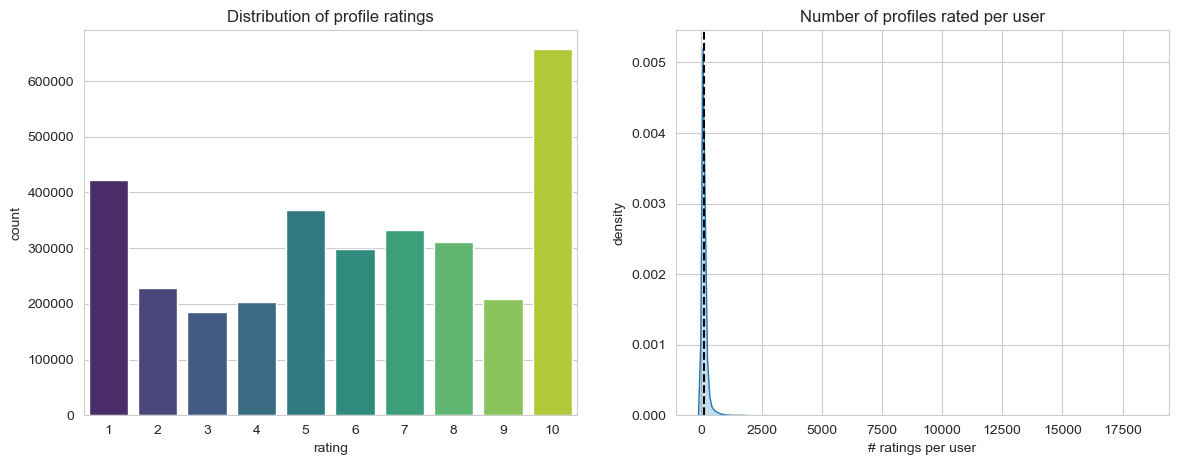

In [12]:
user_freq = ratings[['userID', 'profileID']].groupby('userID').count().reset_index()
user_freq.columns = ['userID', 'n_ratings']


sns.set_style("whitegrid")
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of profile ratings")

plt.subplot(1,2,2)
ax = sns.kdeplot(user_freq['n_ratings'], shade=True, legend=False)
plt.axvline(user_freq['n_ratings'].mean(), color="k", linestyle="--")
plt.xlabel("# ratings per user")
plt.ylabel("density")
plt.title("Number of profiles rated per user")
plt.show()

In [13]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors


# --- 2) Precompute all biases ---
mu = ratings['rating'].mean()
user_mean = ratings.groupby('userID')['rating'].mean()
item_mean = ratings.groupby('profileID')['rating'].mean()
b_u = (user_mean - mu).to_dict()
b_i = (item_mean - mu).to_dict()

# --- 3) Create optimized mappings ---
users = ratings['userID'].unique()
items = ratings['profileID'].unique()
user_to_idx = {u: i for i, u in enumerate(users)}
item_to_idx = {i: j for j, i in enumerate(items)}

# --- 4) Build sparse item-user matrix ---
rows = ratings['profileID'].map(item_to_idx)
cols = ratings['userID'].map(user_to_idx)
data = ratings['rating'] - mu - ratings['userID'].map(b_u) - ratings['profileID'].map(b_i)

item_user_matrix = csr_matrix((data, (rows, cols)), 
                            shape=(len(items), len(users)))

# --- 5) Precompute KNN model for items ---
k = 25  # Increased neighbors for better coverage
knn = NearestNeighbors(n_neighbors=k+1, 
                      metric='cosine', 
                      algorithm='brute', 
                      n_jobs=-1)
knn.fit(item_user_matrix)

# --- 6) Optimized prediction function ---
def predict_rating(u_id, i_id):
    # Base case for new users/items
    if u_id not in user_to_idx or i_id not in item_to_idx:
        return mu + b_u.get(u_id, 0) + b_i.get(i_id, 0)
    
    item_idx = item_to_idx[i_id]
    user_idx = user_to_idx[u_id]
    
    # Find similar items
    distances, indices = knn.kneighbors(item_user_matrix[item_idx])
    
    # Exclude self and unpack arrays
    distances = distances[0][1:]
    neighbor_indices = indices[0][1:]
    
    # Convert to dense array for this user's ratings on similar items
    neighbor_ratings = np.array(item_user_matrix[neighbor_indices, user_idx].todense()).flatten()
    
    # Filter out zero values (no rating)
    mask = neighbor_ratings != 0
    valid_distances = distances[mask]
    valid_ratings = neighbor_ratings[mask]
    
    if len(valid_ratings) == 0:
        return mu + b_u.get(u_id, 0) + b_i.get(i_id, 0)
    
    # Weighted average using inverse distance
    weights = 1 / (valid_distances + 1e-8)
    weighted_sum = (valid_ratings * weights).sum()
    weight_sum = weights.sum()
    
    prediction = mu + b_u.get(u_id, 0) + b_i.get(i_id, 0) + weighted_sum/weight_sum
    return prediction

# --- 7) Test prediction ---
test_user = ratings['userID'].iloc[0]
test_item = ratings['profileID'].iloc[0]
pred = predict_rating(test_user, test_item)
actual = ratings[(ratings['userID'] == test_user) & 
                   (ratings['profileID'] == test_item)]['rating'].values[0]
print(f"Predicted: {pred:.2f}, Actual: {actual}")

Predicted: 3.64, Actual: 4


In [14]:
ratings_test = pd.read_csv('../data/ratings-Test.dat', delimiter=',')
ratings_test['predicted'] = ratings_test.apply(lambda x: predict_rating(x['userID'], x['profileID']), axis=1)
ratings_test.head(10)

,userID,profileID,rating,predicted
0,103155,101955,4,5.657488
1,103155,102751,1,7.329596
2,103155,105618,4,5.353707
3,103155,111862,9,6.625389
4,103155,120657,9,6.300193
5,103155,121116,8,6.740909
6,103155,149653,8,8.971163
7,103155,158028,6,4.292257
8,103155,162707,4,3.928531
9,103155,170904,1,0.410430


In [15]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# MAE
mae = mean_absolute_error(ratings_test['rating'], ratings_test['predicted'])
print(f"MAE:  {mae:.4f}")


MAE:  1.4633


# Naive baseline model
Simply return the average between all the ratings of the user in the training set.

In [19]:
# Correct: make the constant-prediction vector the same length as the test set
mu = ratings['rating'].mean()            # global mean computed on *training*
y_true = ratings_test['rating'].values   # shape (225 924,)

y_pred = np.full_like(y_true, mu, dtype=np.float32)

mae_naive  = mean_absolute_error(y_true, y_pred)

print(f"Baseline MAE:  {mae_naive:.4f}")



Baseline MAE:  2.6545


# Less Naive still Naive model
For eache profile compute its average of rating and return the average rating of the profile for each user

In [20]:
# 1) calcola le medie per profilo dal train
item_means = ratings.groupby('profileID')['rating'].mean().to_dict()


# 2) mappa sul test e riempi i NaN con la media globale
ratings_test['pred_item_mean'] = ratings_test['profileID'] \
    .map(item_means) \
    .fillna(mu)

# 3) calcola MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mae_item  = mean_absolute_error(ratings_test['rating'], ratings_test['pred_item_mean'])

print(f"Item-mean baseline → MAE: {mae_item:.4f}")


Item-mean baseline → MAE: 1.4620
